In [1]:
!pip install gensim==4.1.2

In [148]:
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import numpy as np
import math
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from random import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mean
import pickle

In [119]:
# Use the unprocessed raw data. both spikes and locations measured at 20ms. 
# One should be able to replicate all rat2192 feat and pos files from these sources
raw_spikes = pd.read_csv("https://drive.google.com/uc?id=1-IuXanc2RZICrzqEG7jTg7f_AN9K9Ufl&export=download", header=None)
raw_loc = pd.read_csv("https://drive.google.com/uc?id=1-XHfaaYkfNeQHYefY4uGX4r1q3AKGbic&export=download", header=None)
#speed = pd.read_csv("data/R2192_20ms_speed_direction.csv")

#raw_spikes = raw_spikes.join(speed["speed"])

raw_loc.columns = ["x", "y"]

raw_spikes_revers = raw_spikes[::-1].reset_index(drop = True)
raw_loc_revers = raw_loc[::-1].reset_index(drop = True)

In [120]:
def get_windows(df_len, window_len=10, window_hop=10, skip=0, midpos=-1, drop_incomplete=False):
    num_windows = math.ceil((df_len - skip) / window_hop)
    answer = []
    for i in range(num_windows):
        start = skip + i * window_hop
        end = min(start + window_len, df_len)

        if drop_incomplete and end-start < window_len:
            print(f"Dropping range {start}-{end}")
            break

        if midpos == -1:
            mid = math.floor((start + end) / 2)
        else:
            mid = start + midpos

        answer.append((start, end, mid))

    return answer



def build_sentences(df, window_len = 70, window_hop = 10, skip = 0, max_empty_words = -1, word_ordering = "shuffle"):
    """
    builds sentence vectors from spiking data
    window_len: how many spiking timesteps are used for one sentence
    window_hop: how much to slide the window. if window_len==window_hop there is no overlap. if hop<len, there is overlap.
    max_empty_words: how many consecutive empty words ("_") to keep. if 0, they are removed alltogether. if -1, keep all of them
    word_ordering: "shuffle" or "sort". If several neurons spike in one timestep, how to order them. If the same set of neurons spiked, maybe we should have consistent ordering?
    skip: how many timesteps to skip from the beginning. maybe the rat is training at first and we should discard that data?
    """

    sents = []
    for w in get_windows(len(df), window_len, window_hop, skip):
        start, end, mid = w

        # process one sentence
        sent_words = []
        empty_seq_len = 0
        for j in range(start, end):
            row = df.iloc[j]

            if np.sum(row) == 0:
                empty_seq_len += 1

                if max_empty_words == -1 or max_empty_words >= empty_seq_len:
                    sent_words.append(64)

            else:
                empty_seq_len = 0

                one_spike = row[row == 1].index.tolist()
                two_spikes = row[row == 2].index.tolist()
                three_spikes = row[row == 3].index.tolist()
                four_spikes = row[row == 4].index.tolist()
                word = 4 * four_spikes + 3 * three_spikes + 2 * two_spikes + one_spike

                if word_ordering == "shuffle":
                    shuffle(word)
                else:
                    word.sort()

                sent_words += word

        if len(sent_words) == 0:
            sent_words = [64]

        sents.append(sent_words)

    return sents



def get_locations_past_future(df, window_len=70, window_hop=10, skip=0):
    idx = [False] * len(df)
    for w in get_windows(len(df), window_len, window_hop, skip):
        end = w[1]
        idx[end - 1] = True

    return df[idx]

def get_locations_present(df, window_len=70, window_hop=10, skip=0):
    idx = [False] * len(df)
    for w in get_windows(len(df), window_len, window_hop, skip):
        mid = w[2]
        idx[mid - 1] = True

    return df[idx]

In [121]:
def train_word2vec(sents, vector_len=250, train_size=0.8, window_size=5, sg=0, shrink_windows=True, alpha=0.025, seed=42):
    model = Word2Vec(min_count=1, vector_size=vector_len, window=window_size, max_vocab_size=None, max_final_vocab=None,
                   sg=sg, compute_loss=True, workers=6, shrink_windows=shrink_windows, alpha=alpha, seed=seed)
    # Build vocab from full dataset.
    # In some cases, the word might not have ended up in train set. Then the model would throw an error.
    model.build_vocab(sents)

    train_test_boundary = math.floor(len(sents) * train_size)
    train_sents = sents[:train_test_boundary]
    model.train(corpus_iterable=train_sents, total_examples=len(train_sents), epochs=20, compute_loss=True)
    return model

In [122]:
def build_features(word2vec_model, sents, method="mean"):
    features = []
    for sent in sents:
        vecs = np.array([word2vec_model.wv[word] for word in sent])
        if method == "mean":
            features.append(np.mean(vecs, axis=0))
        else:
            # concatenate instead
            features.append(vecs.flatten())

    if method != "mean":
        # right-pad every row with zeros so that every vector has the same length
        maxlen = max([len(row) for row in features])
        features = [np.append(row, [0] * (maxlen - len(row))) for row in features]
        features = np.array(features)
    return features

In [123]:
def split_df(df, train_ratio):
    idx = math.floor(len(df) * train_ratio)
    return df[:idx], df[idx:]


#wordVecs, sents, locs,
#sent_vecs = build_features(wordVecs, sents, method = "mean")
def benchmark(model: MultiOutputRegressor, X, y, train_ratio=0.8):
    if len(X) != len(y):
        raise Exception(f"different number of sentences and locations: {len(X)} != {len(y)}")

    train_x, test_x = split_df(X, train_ratio)
    train_x = pd.DataFrame(data=train_x)
    test_x = pd.DataFrame(data=test_x)

    train_y, test_y = split_df(locations, train_ratio)

    model = model.fit(train_x, train_y)
    preds = model.predict(test_x)
    preds = preds.T

    dists = np.sqrt((test_y['x'] - preds[0]) ** 2 + (test_y['y'] - preds[1]) ** 2)
    avg_dist = np.mean(dists)

    return avg_dist


In [124]:
MAE_LR = []
MAE_RFR = []

In [125]:
for i in tqdm(range(3010, 10, -10)):

    sents = build_sentences(raw_spikes_revers, window_len=i, window_hop=i, skip=0)
    locations = get_locations_past_future(raw_loc_revers, window_len=i, window_hop=i, skip=0)

    word2vec_model = train_word2vec(sents)
    input_features = build_features(word2vec_model, sents, method="mean")

    avg_dist_lr = benchmark(
    MultiOutputRegressor(LinearRegression()),
    X=input_features,
    y=locations
    )
    MAE_LR.append(avg_dist_lr)


    avg_dist_rfr = benchmark(
    MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
    X=input_features,
    y=locations
    )
    MAE_RFR.append(avg_dist_rfr)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [2:07:23<00:00, 25.48s/it]


In [126]:
sents = build_sentences(raw_spikes, window_len=10, window_hop=10, skip=0)
locations = get_locations_present(raw_loc, window_len=10, window_hop=10, skip=0)

word2vec_model = train_word2vec(sents)
input_features = build_features(word2vec_model, sents, method="mean")

avg_dist_lr = benchmark(
MultiOutputRegressor(LinearRegression()),
X=input_features,
y=locations
)
MAE_LR.append(avg_dist_lr)
    

avg_dist_rfr = benchmark(
MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
X=input_features,
y=locations
)
MAE_RFR.append(avg_dist_rfr)

In [127]:
for i in tqdm(range(10, 3010, 10)):

    sents = build_sentences(raw_spikes, window_len=i, window_hop=i, skip=0)
    locations = get_locations_past_future(raw_loc, window_len=i, window_hop=i, skip=0)

    word2vec_model = train_word2vec(sents)
    input_features = build_features(word2vec_model, sents, method="mean")

    avg_dist_lr = benchmark(
    MultiOutputRegressor(LinearRegression()),
    X=input_features,
    y=locations
    )
    MAE_LR.append(avg_dist_lr)
    

    avg_dist_rfr = benchmark(
    MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=3)),
    X=input_features,
    y=locations
    )
    MAE_RFR.append(avg_dist_rfr)


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [2:05:07<00:00, 25.02s/it]


## Pickle load

In [ ]:
with open('MAE_LR', 'rb') as f:
    MAE_LR = pickle.load(f)

with open('MAE_RFR', 'rb') as f:
    MAE_RFR = pickle.load(f)

In [139]:
len(MAE_LR), len(MAE_RFR)

(601, 601)

## Linear Regression

In [140]:
LR_past_mean = mean(MAE_LR[0:300])
LR_present = MAE_LR[300]
LR_future_mean = mean(MAE_LR[301:601])
LR_past_mean, LR_present, LR_future_mean

(101.17169318361402, 28.170913403104613, 160.57199550990302)

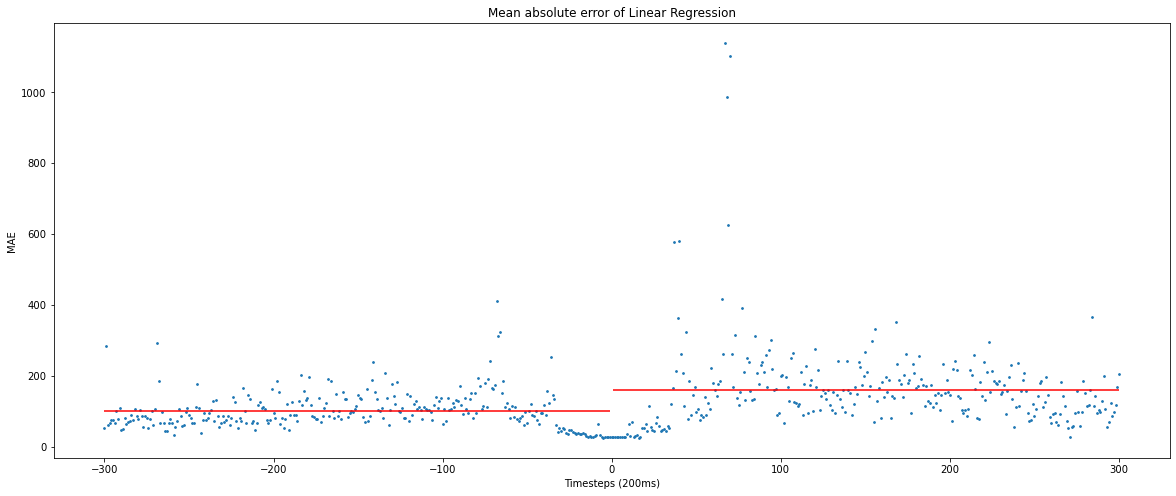

In [141]:
timesteps = list(range(-300,301))

plt.rcParams["figure.figsize"] = (20, 8)
plt.scatter(timesteps, MAE_LR, s = 3)
plt.hlines(y = LR_past_mean, xmin = -300, xmax = -1, colors = "red")
plt.hlines(y = LR_future_mean, xmin = 1, xmax = 300, colors = "red")
plt.title('Mean absolute error of Linear Regression')
plt.xlabel('Timesteps (200ms)')
plt.ylabel('MAE')
plt.show()

In [142]:
LR_past_mean = mean(MAE_LR[270:300])
LR_present = MAE_LR[300]
LR_future_mean = mean(MAE_LR[301:331])
LR_past_mean, LR_present, LR_future_mean

(35.78120515422545, 28.170913403104613, 44.544505534296995)

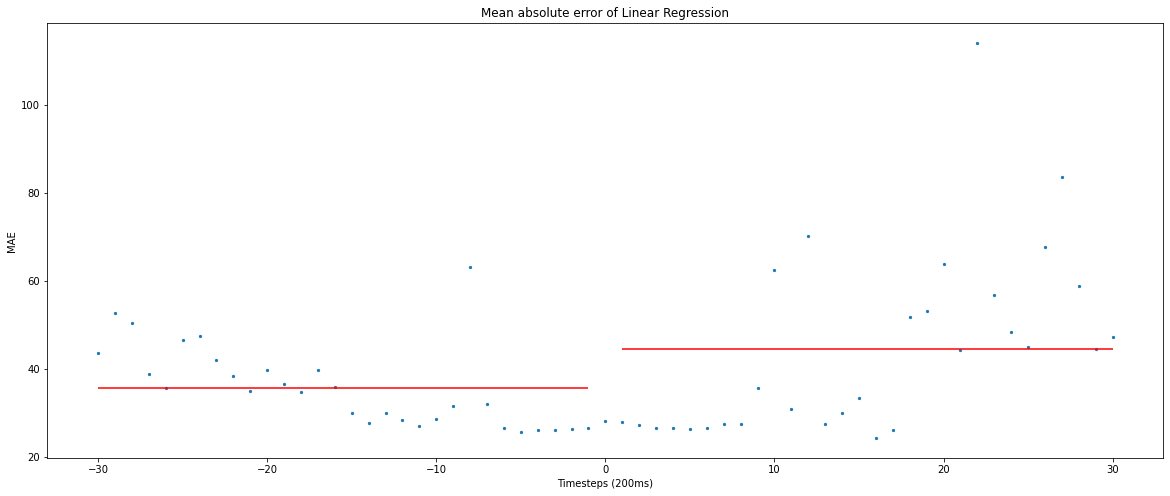

In [143]:
timesteps = list(range(-300,301))

plt.rcParams["figure.figsize"] = (20, 8)
plt.scatter(timesteps[270:331], MAE_LR[270:331], s = 5)
plt.hlines(y = LR_past_mean, xmin = -30, xmax = -1, colors = "red")
plt.hlines(y = LR_future_mean, xmin = 1, xmax = 30, colors = "red")
plt.title('Mean absolute error of Linear Regression')
plt.xlabel('Timesteps (200ms)')
plt.ylabel('MAE')
plt.show()

## Random Forest Regressor

In [144]:
RFR_past_mean = mean(MAE_RFR[0:300])
RFR_present = MAE_RFR[300]
RFR_future_mean = mean(MAE_RFR[301:601])
RFR_past_mean, RFR_present, RFR_future_mean

(32.20260467251024, 25.996488341192443, 31.188641022423496)

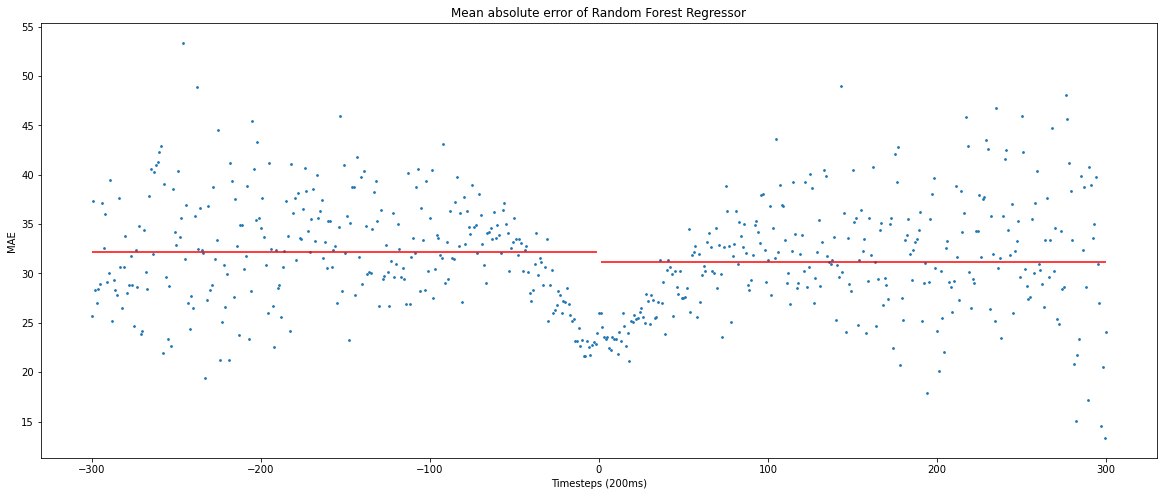

In [145]:
timesteps = list(range(-300,301))

plt.rcParams["figure.figsize"] = (20, 8)
plt.scatter(timesteps, MAE_RFR, s = 3)
plt.hlines(y = RFR_past_mean, xmin = -300, xmax = -1, colors = "red")
plt.hlines(y = RFR_future_mean, xmin = 1, xmax = 300, colors = "red")
plt.title('Mean absolute error of Random Forest Regressor')
plt.xlabel('Timesteps (200ms)')
plt.ylabel('MAE')
plt.show()

In [146]:
RFR_past_mean = mean(MAE_RFR[270:300])
RFR_present = MAE_RFR[300]
RFR_future_mean = mean(MAE_RFR[301:331])
RFR_past_mean, RFR_present, RFR_future_mean

(25.056498080778407, 25.996488341192443, 24.4570744483494)

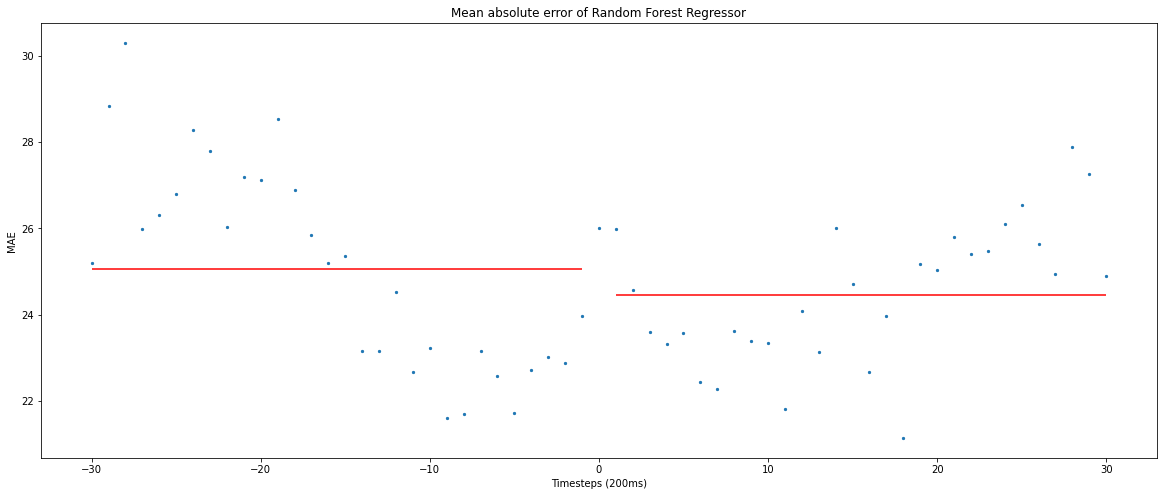

In [147]:
timesteps = list(range(-300,301))

plt.rcParams["figure.figsize"] = (20, 8)
plt.scatter(timesteps[270:331], MAE_RFR[270:331], s = 5)
plt.hlines(y = RFR_past_mean, xmin = -30, xmax = -1, colors = "red")
plt.hlines(y = RFR_future_mean, xmin = 1, xmax = 30, colors = "red")
plt.title('Mean absolute error of Random Forest Regressor')
plt.xlabel('Timesteps (200ms)')
plt.ylabel('MAE')
plt.show()